IMPORTATION DES BIBLIOTHEQUES PYTHON

In [2]:
import os
import os.path
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers
import matplotlib.pyplot as plt

LECTURE DES IMAGES DU DOSSIER

In [3]:
dossier = './dst' #racine de notre dataset
donnee = [] #donnee pour chaque image
race = [] #race qui correspond a chaque image récupéré

SIZE = 128 #Taille de nos image
NBDOSSIER=10 #Nombre de dossier de notre dataset (pour ensuite diviser en catégorie)

for folder in os.listdir(dossier): #on parcours notre dossier
    for file in os.listdir(os.path.join(dossier, folder)):
        if file.endswith("jpg"): #si le fichier est de type .jpg
            race.append(folder) #on ajoute le nom du dossier, soit la race
            img = cv2.imread(os.path.join(dossier, folder, file)) #on lit l'image récupéré
            img_resize = cv2.resize(img, (SIZE,SIZE)) #on redéfinit une taille standard pour chaque image
            donnee.append(img_resize) #on ajoute l'image a donnee
        else:
            continue

CONVERTION DES DONNEES

In [4]:
donnee_liste = np.array(donnee) #donnée sont stockes dans une liste
race_liste = np.array(race) #idem pour les races
#Attention race_liste contient plusieurs mêmes races, on a par exemple 50 fois labrador car notre dataset comportait 50 images de labrador dans le dossier labrador
#Il est plus simple de convertir nos donnee sous forme de liste pour pouvoir mieux les manipuler par la suite

NORMALISATION DES DONNEES

In [5]:
encoder = LabelEncoder() #on encode de facon catégorique
y = encoder.fit_transform(race_liste) #y vaut le nombre de
y = to_categorical(y,NBDOSSIER) #ce qui va nous permettre d'organiser par catégorie (races) nos images
X = donnee_liste/255 #255 représente la couleur

DIVISION / FRACTIONNEMENT DES DONNEES

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=8)
#X_train : représente les valeurs d'entrée d'apprentissage de la première séquence
#X_test : représente les valeurs d'entrée de test de la première séquence
#y_train : représente les valeurs d'entrée d'apprentissage de la première séquence
#y_test : représente les valeurs d'entrée de test de la première séquence
#random_state permet d'éviter le fractionnement aléatoire à chaque fois afin d'avoir des test reproductibles.
#test_size permet de définir explicement nos tailles d'ensembles de test et d'apprentissage.

CREATION DU MODELE

    Modèle séquentiel 1

In [7]:
model = Sequential() # On crée notre modèle séquentiel
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))
#filter : dimension (nombre de filtres)
#kernel_size : hauteur et la largeur de la fenêtre 2d de comparaison
#padding : on remplit uniformément de 0, si on met valid a la place de Same, on ne remplit pas
#activation : comme paramètre relu c'est qu'on utilise la fonction d'activation
#input_shape : cette couche est la première, on doit donc lui donner un tupe qui représente la dimension, ici 128x128 et le 3 représente RVB
model.add(MaxPooling2D(pool_size=(2,2)))
#on sous échantillone en donnant une taille de fenêtre de 2 , 2

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#on ajoute des filtres à notre couche
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#idem
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#idem
model.add(MaxPooling2D(pool_size=(2,2)))
# Trie nos données > effet d'entonnoir : plusieurs couches de plus en plus petite : on tamise en prenant les valeurs les plus importantes

model.add(Flatten())#On aplatit l'entrée les sorties de la dernière couche Conv2D
model.add(Dense(128, activation='relu'))#On distribue
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5)) #réduction de l'overfiting lors de l'entrainement
model.add(Dense(NBDOSSIER, activation = "softmax"))

    Modèle séquentiel 2

In [8]:
model2 = Sequential()
model2.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))
model2.add(MaxPooling2D())

model2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(rate=0.4))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(NBDOSSIER, activation = "softmax"))

CREATION D'IMAGE D'ENTRAINEMENT

In [9]:
#Avant de compiler notre modèle, on crée plus d'images d'entrainement pour éviter l'overfitting
#Overfitting est le fait de sur-apprendre quelques chose
datagen = ImageDataGenerator(
        rotation_range=20, #plage de degrée pour les rotations aléatoires
        zoom_range = 0.20, #zoom aléatoire
        width_shift_range=0.3, #flottant entre -1 et 1 largeur totale
        height_shift_range=0.3, #pareil mais hateur totale
        horizontal_flip=True, #rotation horizontal
        vertical_flip=True) #rotation vertical
datagen.fit(X_train)

COMPILATION DU MODELE


    Nombre de tours d'entrainement / d'apprentissage

In [10]:
epochs=20

    Modèle séquentiel 1

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#on utilise comme optimizer adam avec comme pas de 0.0001, il est important de mettre un pas très petit
#loss est la fonction que le modèle va utiliser pour minimiser les erreurs, ici nous avons choisi categorical_crossentropy car nous sommes faces à un problème de classification entre plusieurs groupes
#metrics=accuracy : nous sommes faces à un problèmes de classification donc il faut utiliser cet argument

chemin_sauvegarde="./entrainement/cp.ckpt"
cp_dir=os.path.dirname(chemin_sauvegarde)# détermine notre dossier d'entrainement
latest=tf.train.latest_checkpoint(cp_dir)#dernier checkpoint de l'entrainement
#checkpoint : point de passage a chaque epochs
model.load_weights(latest)#chargement de l'entrainement sur le dernier checkpoint
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=chemin_sauvegarde, save_weights_only=True,verbose=1) #on crée un checkpoint après chaque epochs, ce qui nous permettra de sauvegarder le tout

history = model.fit_generator(datagen.flow(X_train,y_train),
                              epochs = epochs, #nombre d'épochs
                              validation_data = (X_test,y_test), #nos données
                              callbacks=[cp_callback], #on place notre checkpoint
                              verbose = 1)

c:\users\benja\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.0766 - accuracy: 0.2341  

    Modèle séquentiel 2

In [12]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

chemin_sauvegarde2="./entrainementModel2/cp.ckpt"
cp_dir2=os.path.dirname(chemin_sauvegarde2)
latest2=tf.train.latest_checkpoint(cp_dir2)
model2.load_weights(latest2)
cp_callback2=tf.keras.callbacks.ModelCheckpoint(filepath=chemin_sauvegarde2, save_weights_only=True,verbose=1)

history2 = model2.fit_generator(datagen.flow(X_train,y_train),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              callbacks=[cp_callback2],
                              verbose = 1)

c:\users\benja\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 2.0067 - accuracy: 0.2701 

PHASE DE TEST

    Taille du Test

In [13]:
TAILLETEST=6

    Modèle séquentiel 1

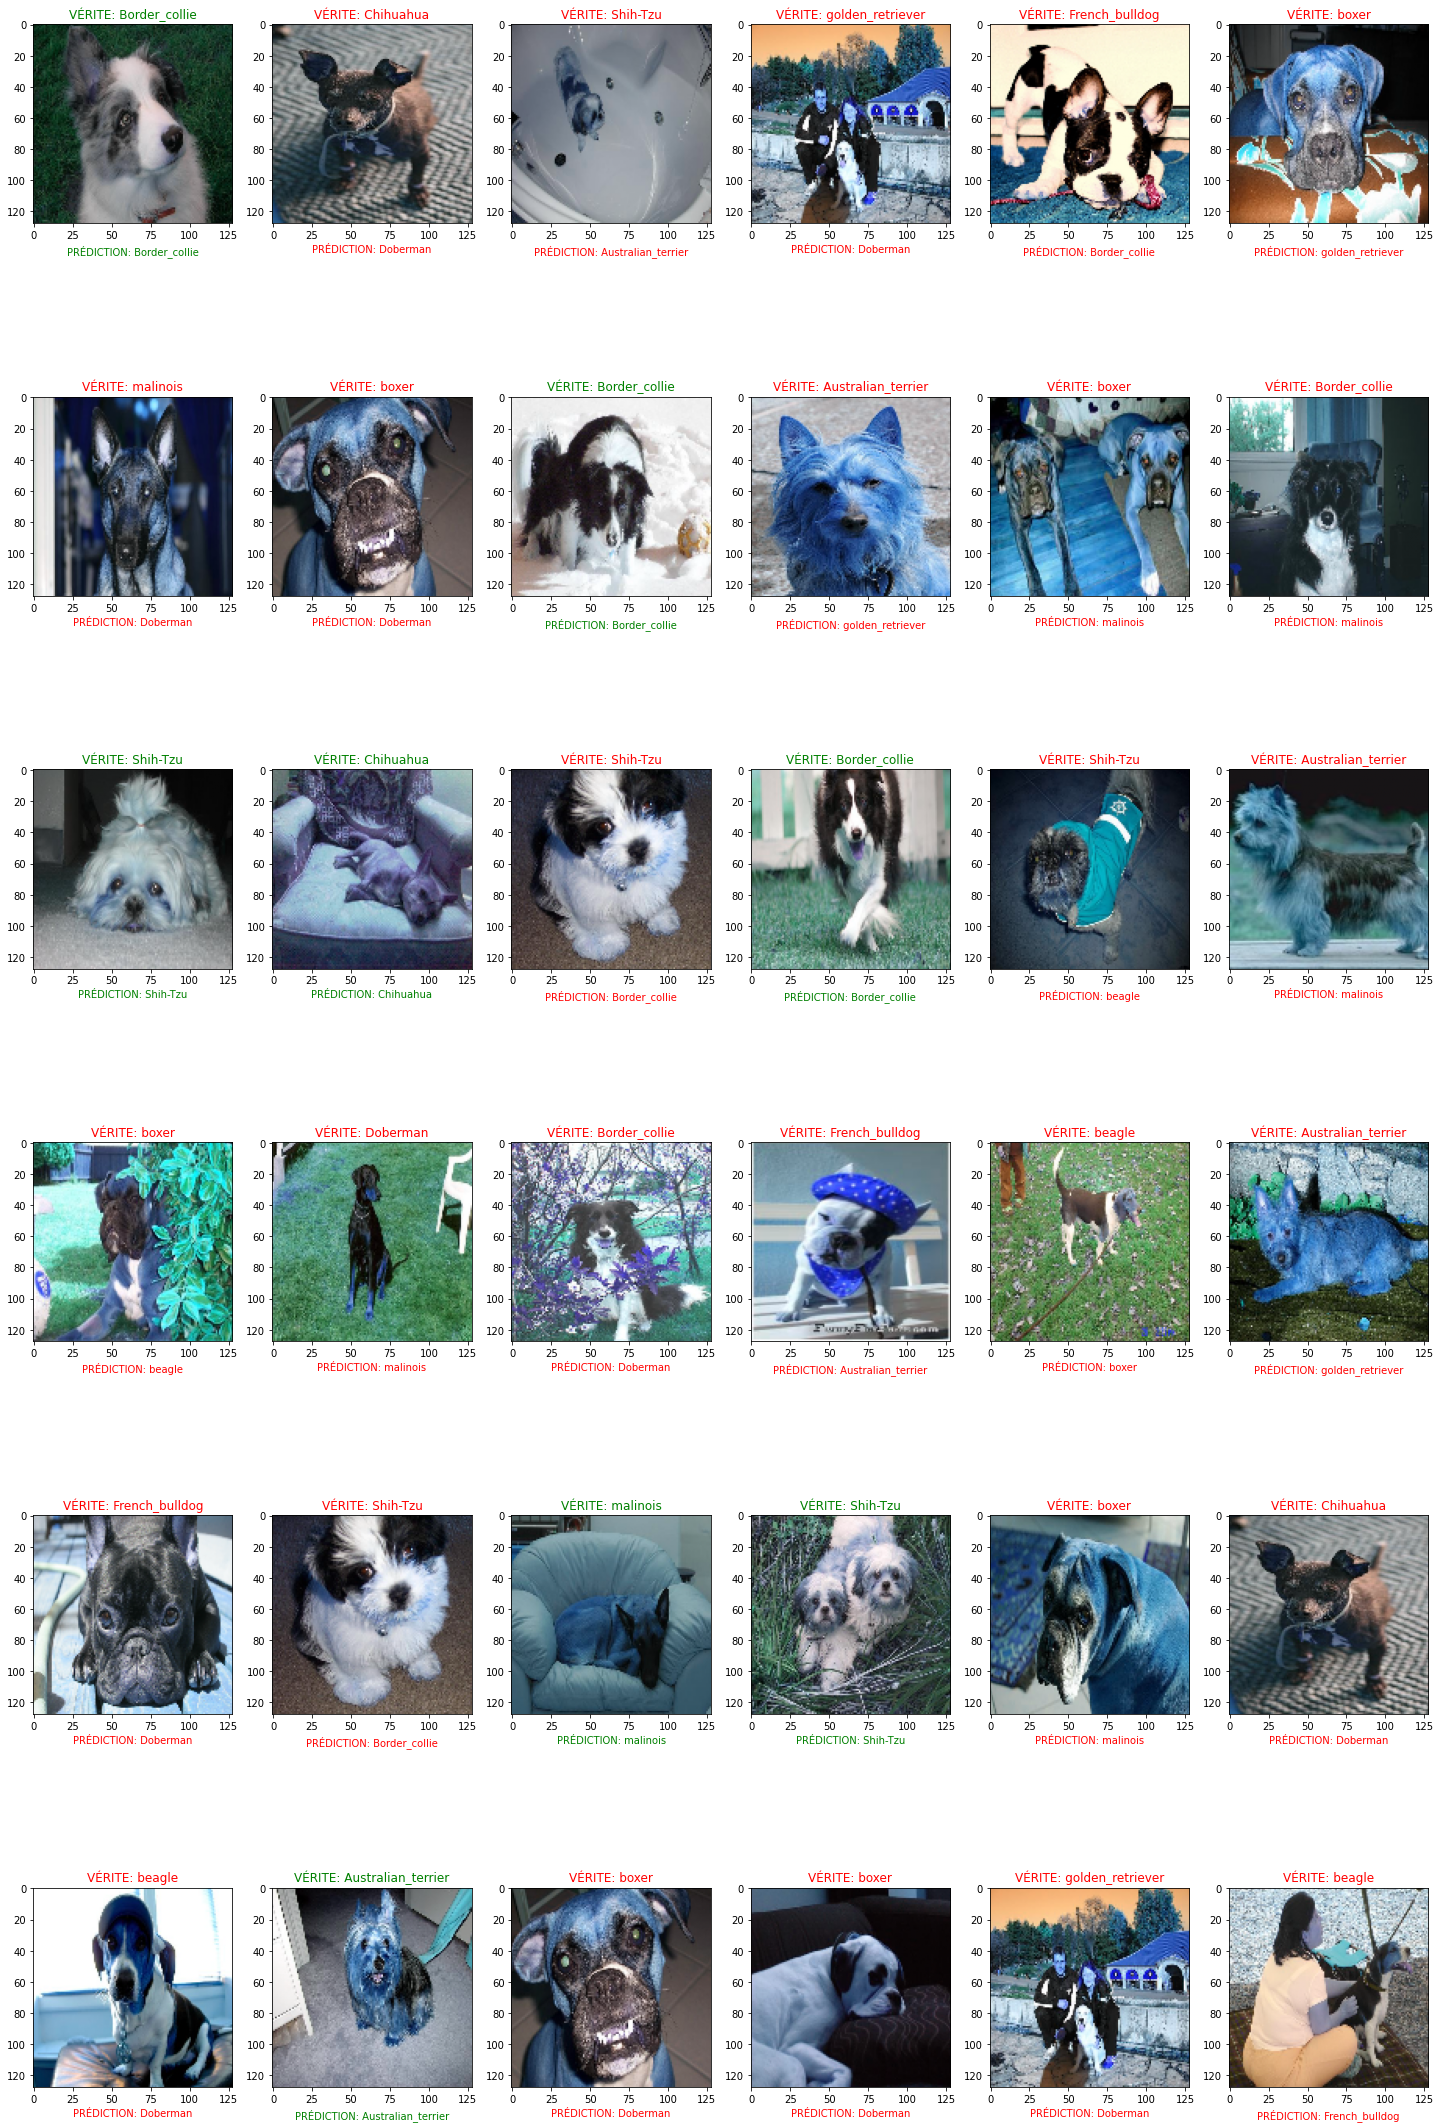

In [14]:
races = np.sort(os.listdir(dossier)) #on récupére toutes les races de chiens soit touts les noms de dossier du dataset
fig, ax = plt.subplots(TAILLETEST,TAILLETEST, figsize=(25, 40)) #représente lignes/colonnes de nos test avec la taille des images

for i in range(TAILLETEST):
    for j in range(TAILLETEST):
        k = int(np.random.random_sample() * len(X_test))
        if(races[np.argmax(y_test[k])] == races[np.argmax(model.predict(X_test)[k])]):#si le véritable nom de race est égale à la prédiction
            ax[i,j].set_title("VÉRITE: " + races[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PRÉDICTION: " + races[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3))
        else:#sinon la prédiction est fausse, elle n'est pas égale au véritable nom de race
            ax[i,j].set_title("VÉRITE: " + races[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PRÉDICTION: " + races[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3))

    Modèle séquentiel 2

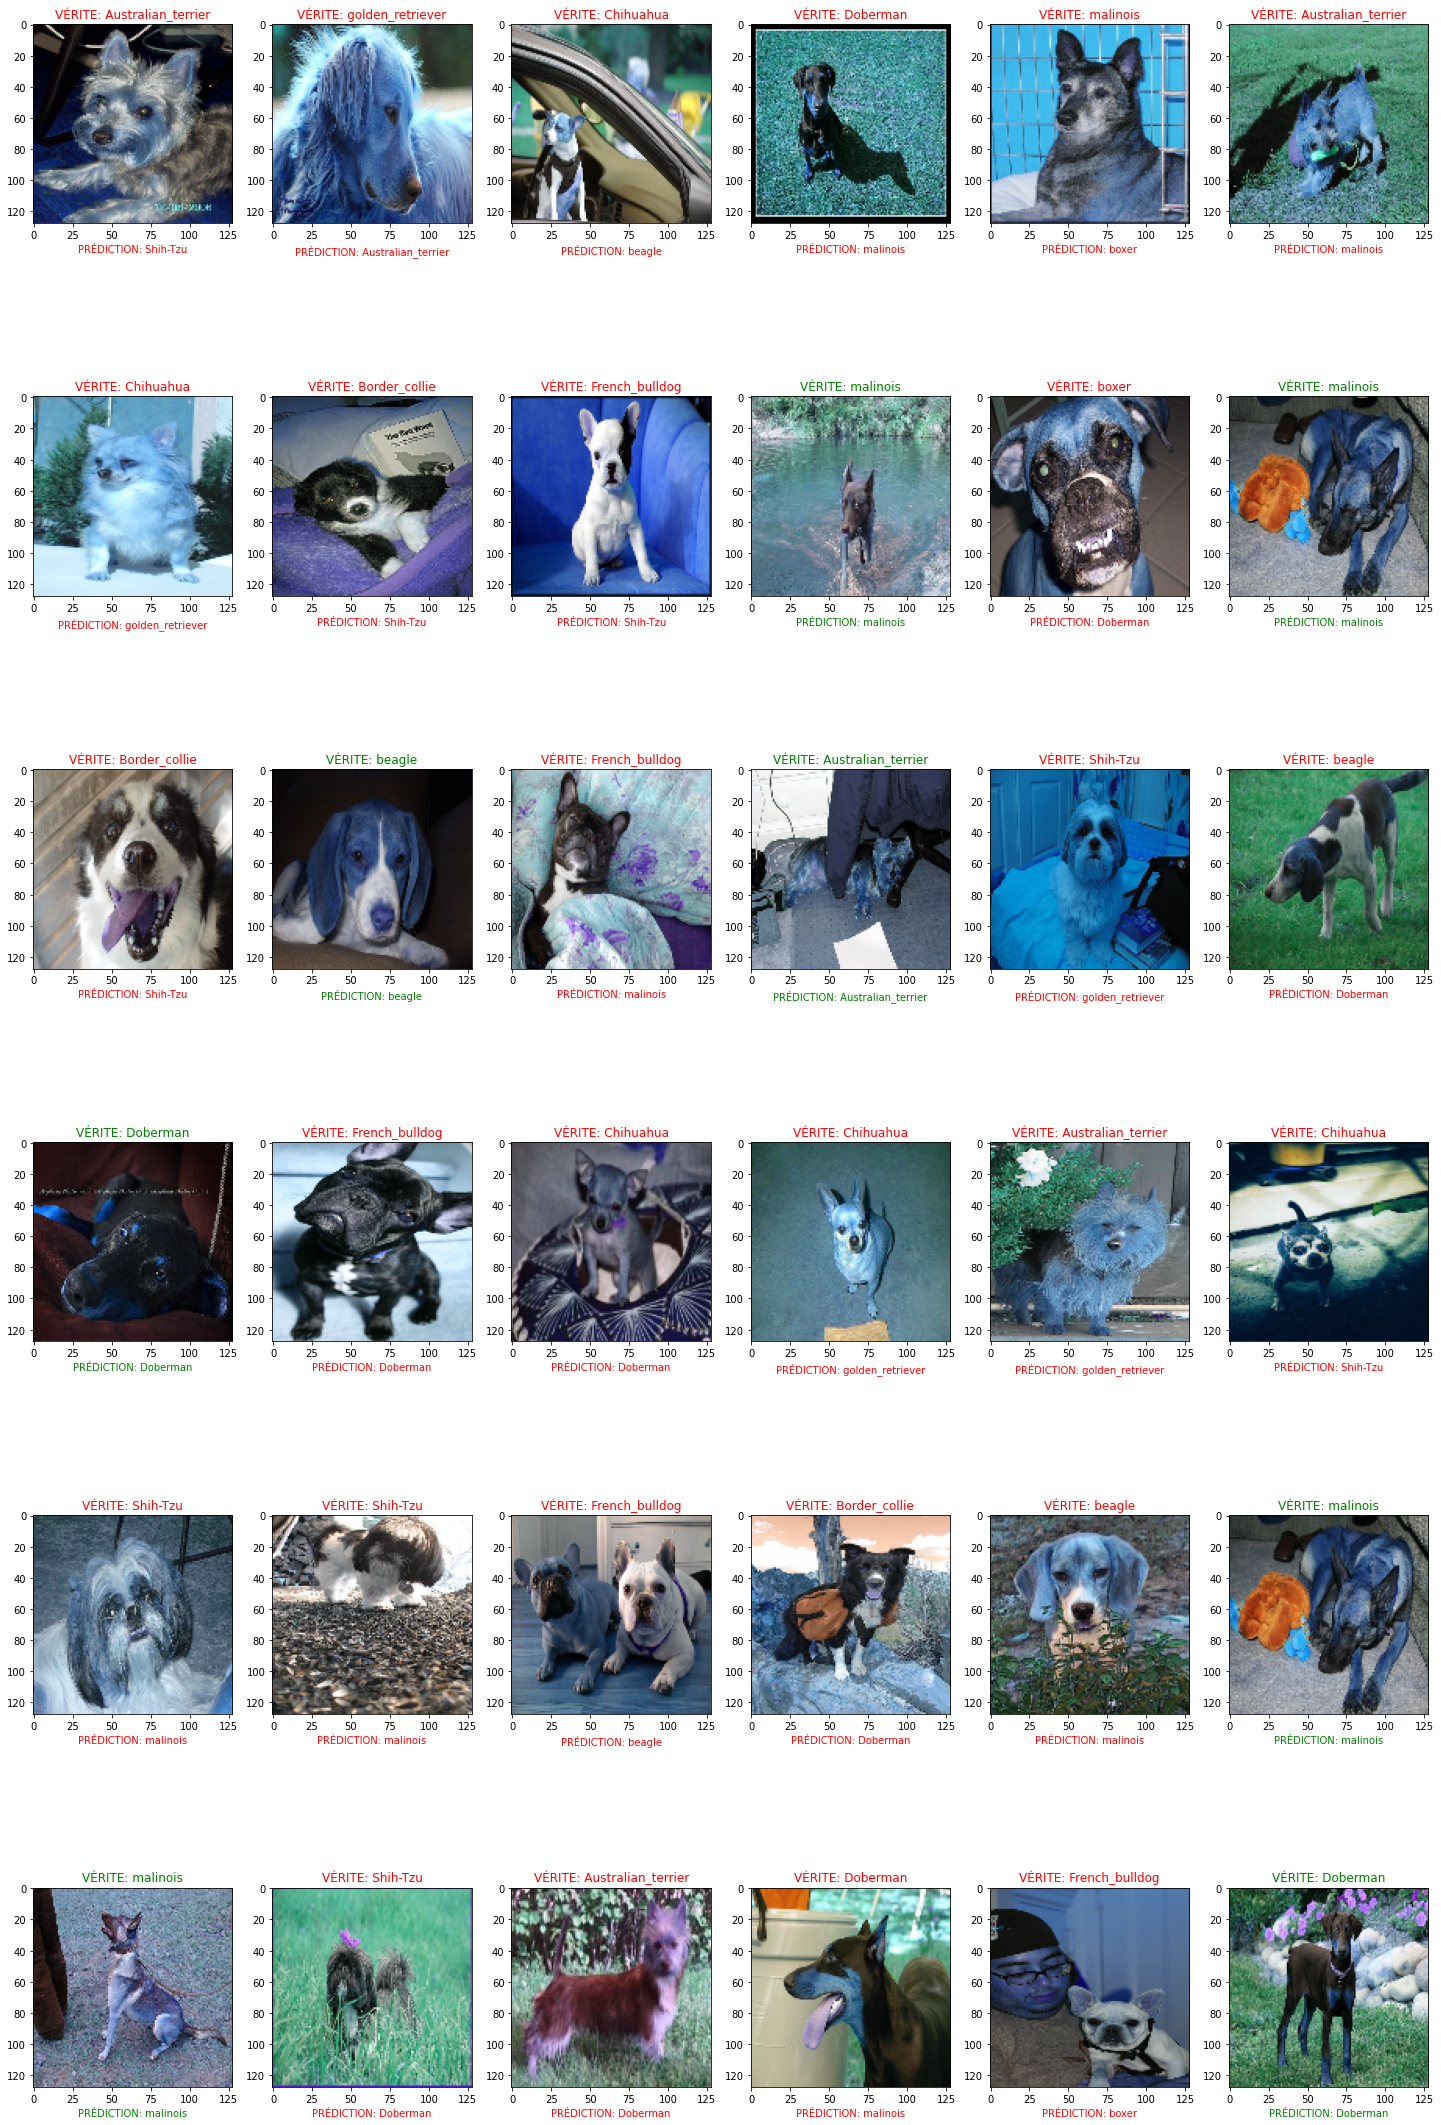

In [17]:
races = np.sort(os.listdir(dossier))
fig, ax = plt.subplots(TAILLETEST,TAILLETEST, figsize=(25, 40))

for i in range(TAILLETEST):
    for j in range(TAILLETEST):
        k = int(np.random.random_sample() * len(X_test))
        if(races[np.argmax(y_test[k])] == races[np.argmax(model2.predict(X_test)[k])]):
            ax[i,j].set_title("VÉRITE: " + races[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PRÉDICTION: " + races[np.argmax(model2.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3))
        else:
            ax[i,j].set_title("VÉRITE: " + races[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PRÉDICTION: " + races[np.argmax(model2.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3))

ILLUSTRATION DE NOS RESULTATS

Text(0.5, 1.0, "Perte de l'entrainement et du Test")

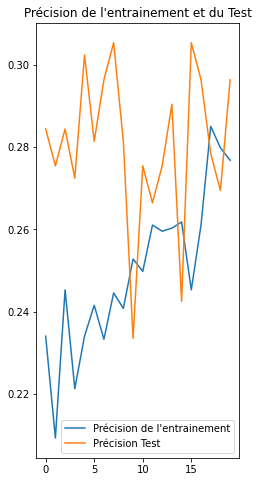

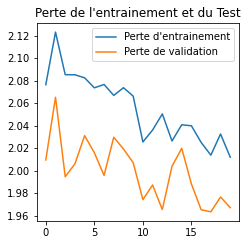

In [15]:
acc = history.history['accuracy'] #history est la génération de notre apprentissage de notre model
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)# on génère une séquence de nombre à partir du nombre d'epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision de l\'entrainement')
plt.plot(epochs_range, val_acc, label='Précision Test')
plt.legend()
plt.title("Précision de l'entrainement et du Test")

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Perte d\'entrainement')
plt.plot(epochs_range, val_loss, label='Perte de validation')
plt.legend()
plt.title("Perte de l'entrainement et du Test")
